In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.optimizer import SPSA
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import QasmSimulator
from qiskit import IBMQ
# for logging & visualization
import logging
from classifiers.callback import CostParamStorage, ParamsStopping
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm

writer = SummaryWriter()
storage = CostParamStorage(writer)

if IBMQ.active_account() is None:
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')
backend = provider.get_backend('ibmq_toronto')
backend

<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>

In [4]:
X, y = Example_4x2(True)()

In [5]:
var_form = RealAmplitudes(2, reps=1)
quantum_instance = QuantumInstance(backend=QasmSimulator(), shots=2**13, basis_gates=backend.configuration().basis_gates, initial_layout=Qasvm_Mapping_4x2(backend).layout, measurement_error_mitigation_cls=CompleteMeasFitter, optimization_level=2, seed_transpiler=0)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=1, k=0.1, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, idle_wires=False)

8


┌───┐                                                                                                                             ┌───┐┌─┐
 a_0: ────┤ H ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─┤ H ├┤M├
      ┌───┴───┴────┐     ┌────────────┐┌───────────────────────────────────────┐┌─────────────────────────────────────┐┌────────────────┐ │ └───┘└╥┘
 i_0: ┤ RY(θ_i[0]) ├──■──┤ RY(θ_i[2]) ├┤1                                      ├┤1                                    ├┤1               ├─┼───────╫─
      ├────────────┤┌─┴─┐├────────────┤│                                       ││                                     ││                │ │       ║ 
 i_1: ┤ RY(θ_i[1]) ├┤ X ├┤ RY(θ_i[3]) ├┤2 UCRY(0.72295,-0.60554,-2.507,2.6396) ├┤2 UCRZ(-1.0039,2.2997,-1.031,2.2163) ├┤2               ├─┼───────╫─
      └────────────┘└───┘└────────────┘│                                       ││                                     ││  UCRX(π,π,0,0) │ │       ║ 
xi_0: ─────────────────────────────────┤0                                      ├┤0                                    ├┤                ├─X───────╫─
                                       └───────────────────────────────────────┘└─────────────────────────────────────┘│                │ │  ┌─┐  ║ 
yi_0: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0               ├─┼──┤M├──╫─
      ┌────────────┐     ┌────────────┐┌───────────────────────────────────────┐┌─────────────────────────────────────┐├────────────────┤ │  └╥┘  ║ 
 j_0: ┤ RY(θ_j[0]) ├──■──┤ RY(θ_j[2]) ├┤1                                      ├┤1                                    ├┤1               ├─┼───╫───╫─
      ├────────────┤┌─┴─┐├────────────┤│                                       ││                                     ││                │ │   ║   ║ 
 j_1: ┤ RY(θ_j[1]) ├┤ X ├┤ RY(θ_j[3]) ├┤2 UCRY(0.72295,-0.60554,-2.507,2.6396) ├┤2 UCRZ(-1.0039,2.2997,-1.031,2.2163) ├┤2               ├─┼───╫───╫─
      └────────────┘└───┘└────────────┘│                                       ││                                     ││  UCRX(π,π,0,0) │ │   ║   ║ 
xj_0: ─────────────────────────────────┤0                                      ├┤0                                    ├┤                ├─X───╫───╫─
                                       └───────────────────────────────────────┘└─────────────────────────────────────┘│                │┌─┐  ║   ║ 
yj_0: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0               ├┤M├──╫───╫─
                                                                                                                       └────────────────┘└╥┘  ║   ║ 
 c: 3/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═══╩═══╩═
                                                                                                                                          2   1   0

In [6]:
from tqdm.notebook import tqdm
epochs = 2**10
last_avg = 2**7

optimizer = SPSA(qasvm)
optimizer.calibrate(epochs)

storage = CostParamStorage(writer)
early_stopping = ParamsStopping(patiance=1, last_avg=last_avg, tol=0.1)

for epoch in tqdm(range(epochs)):
    optimizer.step(epoch)
    storage(epoch, qasvm.cost_fn, qasvm.parameters)
    if early_stopping(qasvm.parameters, epoch):
        break

qasvm.parameters = early_stopping.best_params


  0%|          | 0/1024 [00:00<?, ?it/s]

In [7]:
storage.data

,θ[0],θ[1],θ[2],θ[3],Cost
0,3.185344,0.291304,1.508336,-0.106622,9.422120
1,4.341581,1.447540,2.664572,-1.262858,9.709229
2,3.685156,0.791115,2.008147,-0.606433,0.417238
3,3.637991,0.838279,2.055312,-0.653598,0.463135
4,3.546128,0.930143,1.963448,-0.561734,0.589844
...,...,...,...,...,...
131,3.895235,0.902475,1.825504,-0.518611,0.438477
132,3.886109,0.893348,1.834630,-0.527737,0.276611
133,3.890613,0.897853,1.830126,-0.532242,0.573486
134,3.897026,0.904266,1.823713,-0.525829,0.607666


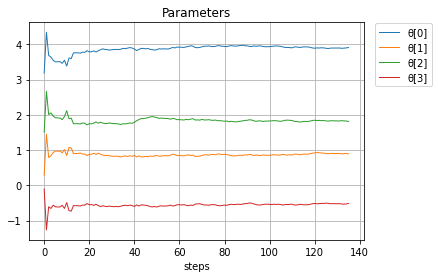

In [8]:
storage.plot_params()

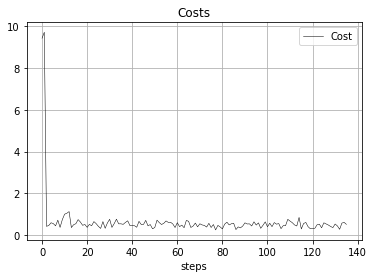

In [9]:
storage.plot()

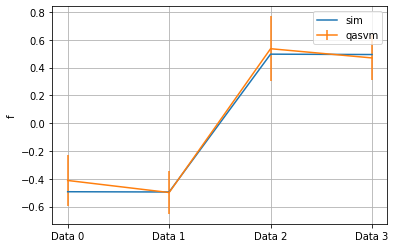

In [10]:
svm = BinarySVM(kernel=Kernel('SingleQubit'), C=None, k=0.1, mutation='REDUCED_QASVM')
svm.fit(X, y)
compare_svm_and_qasvm(svm=svm, qasvm=qasvm)

In [11]:
svm.dual_objective_value

0.4936755897036423

In [12]:
qasvm.cost_fn(qasvm.parameters)

0.316406266369453

In [13]:
qasvm.parameters

{Parameter(θ[0]): 3.881252690674504,
 Parameter(θ[1]): 0.8681284993457994,
 Parameter(θ[2]): 1.8310945149049875,
 Parameter(θ[3]): -0.5564446980944765}